In [243]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Path to the .mseed file
data_directory = '../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1973-07-04HR00_evid00114.mseed' #request
mseed_file = f'{data_directory}'

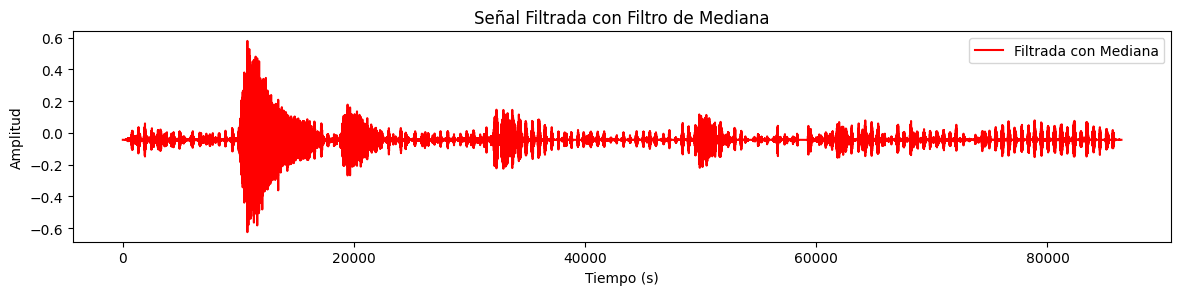

In [244]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Read the mseed file
st = read(mseed_file)
tr = st[0].copy()  # Obtain the first trace

# Apply a highpass filter
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtain filtered trace data
tr_times = tr.times()
tr_data = tr.data

# Min-Max normalization
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Apply a Median Filter
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualize the signals
plt.figure(figsize=(12, 8))

# Filtered Signal with Median
plt.subplot(3, 1,1)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.savefig('mediana.png')
plt.legend()

plt.tight_layout()
plt.show()

In [246]:
import noisereduce as nr
sample_rate = 1 / (tr_times[1] - tr_times[0])  # Calculate sampling rate
signal_cleaned = nr.reduce_noise(y=tr_data_median_filtered, sr=sample_rate, time_mask_smooth_ms=40000)

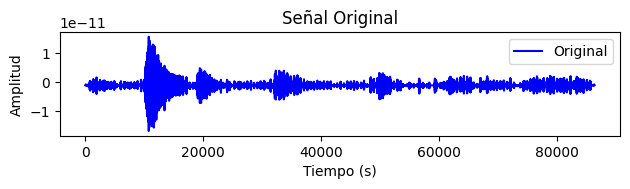

In [247]:
plt.subplot(3, 1, 1)
plt.plot(tr_times, signal_cleaned , 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

In [248]:
import re
def deserializar_respuesta(respuesta_texto):
    # Expresión regular para capturar valores de 'sta', 'lta' y 'confirmation'
    patron = r"'sta':\s*(\d+),\s*'lta':\s*(\d+),\s*'confirmation':\s*'(yes|no)'"
    
    # Buscar el patrón en el texto de respuesta
    match = re.search(patron, respuesta_texto)
    
    if match:
        sta = int(match.group(1))  # Extraer y convertir 'sta' a entero
        lta = int(match.group(2))  # Extraer y convertir 'lta' a entero
        confirmation = match.group(3)  # Extraer 'confirmation' (yes o no)
        return sta, lta, confirmation
    else:
        raise ValueError("No se pudo deserializar la respuesta. Formato inválido.")


In [249]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()

gemini_api_key = os.getenv("API_KEY")

def upload_to_gemini(path, mime_type=None):
  file = genai.upload_file(path, mime_type=mime_type)
  return file

genai.configure(api_key=gemini_api_key)

generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-pro",
  generation_config=generation_config,
)

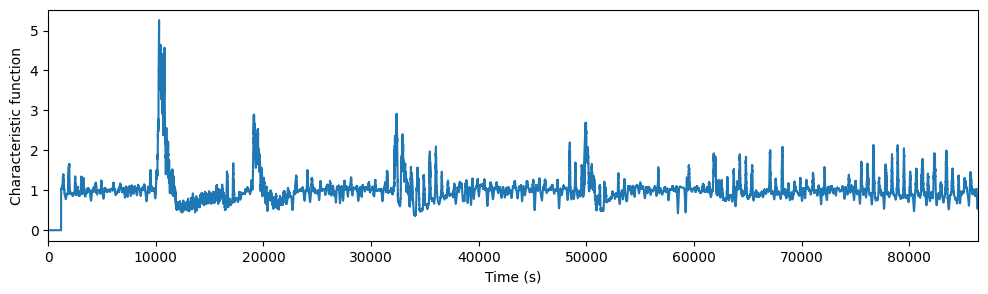

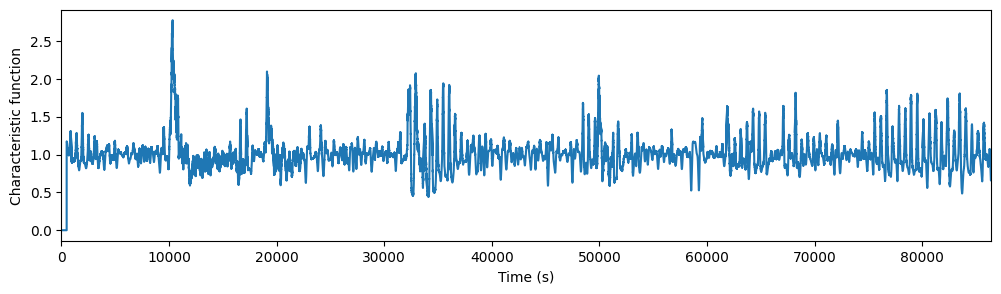

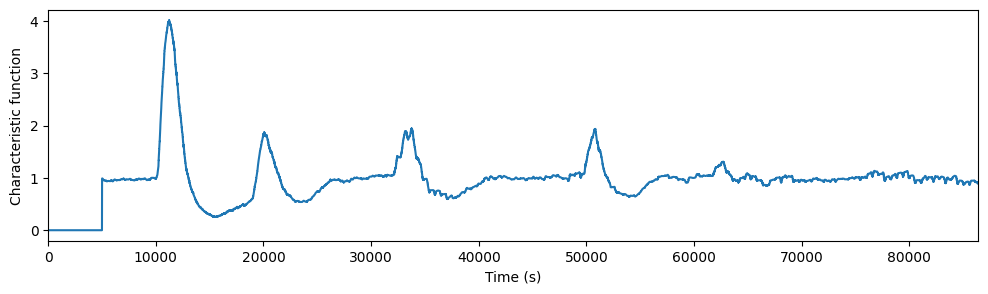

In [250]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

confirmation = "no"  # You want to set confirmation to "no" to begin the while loop
i = 0

# Sampling frequency of the trace
df = tr.stats.sampling_rate

while confirmation != "yes":
    if i == 0:
        # Default STA/LTA window lengths
        sta_len = 60  # Short-term window in seconds
        lta_len = 1200  # Long-term window in seconds
    else:
        # Use the updated window lengths from the user response
        sta_len, lta_len, confirmation = deserializar_respuesta(response.text)

    # Run Obspy's STA/LTA to obtain a characteristic function
    cft = classic_sta_lta(signal_cleaned, int(sta_len * df), int(lta_len * df))

    # Define the minimum event duration (in seconds)
    min_duration = 420  # Adjust as per requirements
    # Convert minimum duration to samples
    min_duration_samples = int(min_duration * df)

    # Plot the characteristic function
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, cft)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    plt.savefig('caracteristica.png')  # Save the plot as an image

    response = model.generate_content([
        upload_to_gemini("caracteristica.png", mime_type="image/png"),
        "The graph is improving, but we need to optimize it further. Please suggest a new value for the STA and LTA windows to obtain a better graph. Respond **only** in the following format: {'sta': <new_sta_value>, 'lta': <new_lta_value>, 'confirmation': <yes or no>}. Make sure the response contains only values in this format."
    ])
    
    i += 1  # Increment the loop counter


In [251]:
import json
import re

thresholds = []

response = model.generate_content([
    upload_to_gemini("caracteristica.png", mime_type="image/png"), 
    "Analyze the graph and identify the earthquake signals. For each event, provide the 'on' and 'off' thresholds along with the approximate time and the probability of it being an earthquake, using **only** the format below. Your response must strictly follow this format and the number of thresholds must match the number of events in the graph: thresholds = [\n\
    {'on': 00.0, 'off': 1, 'time_init': T1, 'time_end': T1, 'probability': P1},\n\
    {'on': 00.0, 'off': 1, 'time_init': T2, 'time_end': T1, 'probability': P2}\n\
    # Add more events as necessary\n\
]\n\
Ensure the 'on' 1 value is given as a single value matching the left Y-axis at the start of each event, and use 1 as the 'off' value. Also, provide the approximate time as a single value for each event based on the X-axis, and include a probability (0-100%) for each event indicating the likelihood of it being an earthquake."
])

response_text = response.text.strip()

try:
    thresholds_str = response_text.split('thresholds = ')[1].strip().rstrip(']') + ']'
    thresholds_str = thresholds_str.replace("'", '"')
    thresholds_str = re.sub(r'(\d+)%', r'\1', thresholds_str)
    thresholds = json.loads(thresholds_str)
    adjusted_thresholds = []
    for event in thresholds:
        probability = float(event['probability'])  # Convertir a float
        if probability >= 80:
            adjusted_event = {
                'on': event['on'] * 0.9,
                'off': event['off'],
                'time_init': event['time_init'] * 0.9,
                'time_end': event['time_end'] * 1.1,
                'probability': probability
            }
            adjusted_thresholds.append(adjusted_event)

            thresholds = adjusted_thresholds
            print(thresholds)

except (IndexError, json.JSONDecodeError) as e:
    print("Error al procesar la respuesta:", str(e))

[{'on': 0.9, 'off': 1, 'time_init': 9000.0, 'time_end': 19800.0, 'probability': 90.0}]
[{'on': 0.9, 'off': 1, 'time_init': 9000.0, 'time_end': 19800.0, 'probability': 90.0}, {'on': 1.08, 'off': 1, 'time_init': 45000.0, 'time_end': 60500.00000000001, 'probability': 85.0}]


Evento detectado: [67411 86384] con tiempo 10175.245283018869 - 13039.094339622641
Evento detectado: [326470 344324] con tiempo 49278.49056603773 - 51973.43396226415
Se encontraron 2 eventos válidos.


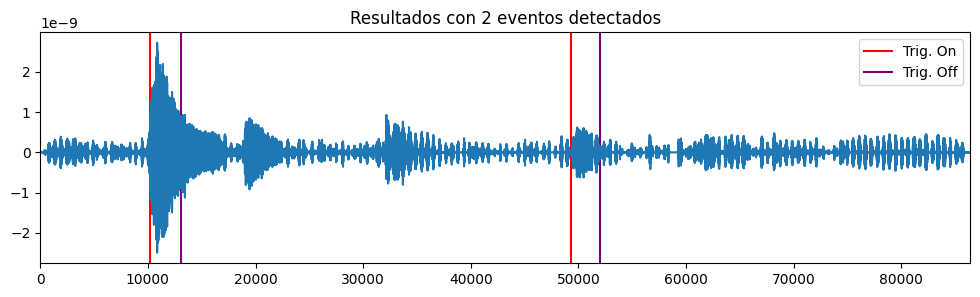

In [252]:
import numpy as np
import matplotlib.pyplot as plt

filtered_on_off = []
min_duration_samples = 420
detected_events = set()

for idx, thr in enumerate(thresholds):
    thr_on = max(thr['on'], 1.1)
    thr_off = thr['off']
    
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    
    temp_filtered = []
    for triggers in on_off:
        event_start_time = tr_times[triggers[0]]
        event_end_time = tr_times[triggers[1]]
        
        if (triggers[1] - triggers[0]) >= min_duration_samples and \
            event_start_time >= thresholds[idx]['time_init'] and \
            event_end_time <= thresholds[idx]['time_end']:

            print(f"Evento detectado: {triggers} con tiempo {event_start_time} - {event_end_time}")
            
            event_range = range(triggers[0], triggers[1] + 1)
            if not any(time in detected_events for time in event_range):
                temp_filtered.append(triggers)
                detected_events.update(event_range)
    
    temp_filtered = np.array(temp_filtered)
    
    if len(temp_filtered) > 0:
        filtered_on_off.extend(temp_filtered.tolist())

if len(filtered_on_off) > 0:
    print(f"Se encontraron {len(filtered_on_off)} eventos válidos.")

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
    for i in range(len(filtered_on_off)):
        triggers = filtered_on_off[i]
        ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
        ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")
    
    ax.plot(tr_times, tr_data)
    ax.set_xlim([min(tr_times), max(tr_times)])

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.title(f"Resultados con {len(filtered_on_off)} eventos detectados")
    plt.show()
else:
    print("No se encontraron eventos que cumplan la duración mínima en ninguno de los umbrales.")


In [253]:
filtered_on_off = np.array(filtered_on_off)
filtered_on_off = filtered_on_off / df
filtered_on_off

array([[10175.24528302, 13039.09433962],
       [49278.49056604, 51973.43396226]])